source: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/basic_regression.ipynb

# Predict house prices: regression

In a *regression* problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where we aim to predict a discrete label (for example, where a picture contains an apple or an orange). 

This notebook builds a model to predict the median price of homes in a Boston suburb during the mid-1970s. To do this, we'll provide the model with some data points about the suburb, such as the crime rate and the local property tax rate.
This example uses the `tf.keras` API, see [this guide](https://www.tensorflow.org/guide/keras) for details.

(Tony) 回歸(regression)問題, 輸出是預測一連續的數值, 像是房價或機率  
(Tony) 這個筆記目標建立一個模型能夠預測 1970 年中期波士頓郊區房屋的價格  
(Tony) 採用的框架為 `tf.keras`  

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

1.4.0


## The Boston Housing Prices dataset

This [dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) is accessible directly in TensorFlow. Download and shuffle the training set:  
(Tony) 波士頓房價資料集  
(Tony) 可直接透過 keras API 下載, 該 API 同時會分成 train and test 兩類資料  

In [2]:
boston_housing = keras.datasets.boston_housing

(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

# Shuffle the training set
order = np.argsort(np.random.random(train_labels.shape))
train_data = train_data[order]
train_labels = train_labels[order]

### Examples and features

This dataset is much smaller than the others we've worked with so far: it has 506 total examples are split between 404 training examples and 102 test examples:  
(Tony) 這個資料集的數量非常的少  
(Tony) 一共只有 506 筆 data, 區分成 404 筆的訓練資料和 102 筆的測試資料  

In [3]:
print("Training set: {}".format(train_data.shape))  # 404 examples, 13 features
print("Testing set:  {}".format(test_data.shape))   # 102 examples, 13 features

Training set: (404, 13)
Testing set:  (102, 13)


The dataset contains 13 different features:  
(Tony) 這資料集包含 13 個不同欄位(features)  

1.   Per capita crime rate.  
     犯罪率  
2.   The proportion of residential land zoned for lots over 25,000 square feet.  
     超過 25,000 平方英尺住宅用地比例
3.   The proportion of non-retail business acres per town.  
     每個城鎮非零售業務佔的比例
4.   Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).  
     是否鄰近查爾斯河  
5.   Nitric oxides concentration (parts per 10 million).  
     一氧化氮濃度
6.   The average number of rooms per dwelling.  
     每棟住宅的平均房間數
7.   The proportion of owner-occupied units built before 1940.  
     1940 年前自住單位的比例
8.   Weighted distances to five Boston employment centers.  
     到波士頓五個就業中心的加權距離
9.   Index of accessibility to radial highways.  
     徑向高速公路的可達性指數
10.  Full-value property-tax rate per $10,000.  
     每10,000美元的全額物業稅率
11.  Pupil-teacher ratio by town.  
     城鎮的學生與教師比例
12.  1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.  
     Bk 是指按城鎮劃分的黑人比例
13.  Percentage lower status of the population.  
     人口比例較低的百分比

Each one of these input data features is stored using a different scale. Some features are represented by a proportion between 0 and 1, other features are ranges between 1 and 12, some are ranges between 0 and 100, and so on. This is often the case with real-world data, and understanding how to explore and clean such data is an important skill to develop.

Key Point: As a modeler and developer, think about how this data is used and the potential benefits and harm a model's predictions can cause. A model like this could reinforce societal biases and disparities. Is a feature relevant to the problem you want to solve or will it introduce bias? For more information, read about [ML fairness](https://developers.google.com/machine-learning/fairness-overview/).

In [4]:
print(train_data[0])  # Display sample features, notice the different scales

[7.8750e-02 4.5000e+01 3.4400e+00 0.0000e+00 4.3700e-01 6.7820e+00
 4.1100e+01 3.7886e+00 5.0000e+00 3.9800e+02 1.5200e+01 3.9387e+02
 6.6800e+00]


Use the [pandas](https://pandas.pydata.org) library to display the first few rows of the dataset in a nicely formatted table:  
(Tony) 使用 Pandas 顯示資料集前幾筆資料 and 把 13 欄位分別取個簡稱  

In [5]:
import pandas as pd

column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
                'TAX', 'PTRATIO', 'B', 'LSTAT']

df = pd.DataFrame(train_data, columns=column_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.07875,45.0,3.44,0.0,0.437,6.782,41.1,3.7886,5.0,398.0,15.2,393.87,6.68
1,4.55587,0.0,18.10,0.0,0.718,3.561,87.9,1.6132,24.0,666.0,20.2,354.70,7.12
2,0.09604,40.0,6.41,0.0,0.447,6.854,42.8,4.2673,4.0,254.0,17.6,396.90,2.98
3,0.01870,85.0,4.15,0.0,0.429,6.516,27.7,8.5353,4.0,351.0,17.9,392.43,6.36
4,0.52693,0.0,6.20,0.0,0.504,8.725,83.0,2.8944,8.0,307.0,17.4,382.00,4.63


### Labels

The labels are the house prices in thousands of dollars. (You may notice the mid-1970s prices.)  
(Tony) 標籤(label) 當然就是我們的房價, 單位是 1000 美元  

In [6]:
print(train_labels[0:10])  # Display first 10 entries

[32.  27.5 32.  23.1 50.  20.6 22.6 36.2 21.8 19.5]


## Normalize features

It's recommended to normalize features that use different scales and ranges. For each feature, subtract the mean of the feature and divide by the standard deviation:  
(Tony) 建議對特徵值做正規化(normalize)  
(Tony) 分別對 13 欄位所有 data 做 nomalize val. = (feature - 平均數(mean)) / 標準差(standard deviation)  

In [7]:
# Test data is *not* used when calculating the mean and std

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

print(train_data[0])  # First training sample, normalized

[-0.39725269  1.41205707 -1.12664623 -0.25683275 -1.027385    0.72635358
 -1.00016413  0.02383449 -0.51114231 -0.04753316 -1.49067405  0.41584124
 -0.83648691]


Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model more dependent on the choice of units used in the input.  
(Tony) 如果不做正規化可能也能夠收斂  
(Tony) 但可能造成訓練困難 or 較花時間  
(Tony) 而且預測結果可能會和輸入特徵值的單位有相關聯  

## Create the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.  
(Tony) 讓我們來建立機器學習模型吧  
(Tony) 用 Keras 裡的 `Sequential` 模式建立  
(Tony) 加入兩個全連接(dense)隱藏層和一個輸出層, 輸出值為單一連續數值(也就是房價啦)  

In [8]:
def build_model():
  model = keras.models.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu,
                       input_shape=(train_data.shape[1],)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


## Train the model

The model is trained for 500 epochs, and record the training and validation accuracy in the `history` object.  
(Tony) 設定訓練次數(epoch) 為 500 回合  
(Tony) 把訓練和驗證準確率記錄在 `history` 物件中  
(Tony) call fit() 開始訓練吧  

In [11]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

# Store training stats
history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

Visualize the model's training progress using the stats stored in the `history` object. We want to use this data to determine how long to train *before* the model stops making progress.  
(Tony) 使用 `history` 物件可以把訓練進度視覺化顯示  

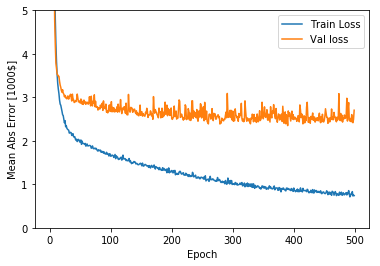

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [1000$]')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0, 5])

plot_history(history)

This graph shows little improvement in the model after about 200 epochs. Let's update the `model.fit` method to automatically stop training when the validation score doesn't improve. We'll use a *callback* that tests a training condition for  every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

You can learn more about this callback [here](https://www.tensorflow.org/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping).  
(Tony) 從圖表上看(訓練資料)在 200 次以後進步的幅度變很小  
(Tony) 做個修改當驗證分數沒有獲得進步時, 就會自動停止訓練動作  
(Tony) 請參考下面 code 新增一個 early_stop 的 callback function  
(Tony) 從下圖看大約訓練了 185 次就提早停止了  


....................................................................................................
..........................................

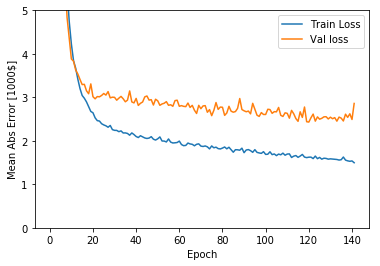

In [13]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

The graph shows the average error is about \\$2,500 dollars. Is this good? Well, \$2,500 is not an insignificant amount when some of the labels are only $15,000.

Let's see how did the model performs on the test set:  
(Tony) 訓練資料平均預測的誤差在 $2500 美元左右  
(Tony) 這結果好嗎?  

In [14]:
[loss, mae] = model.evaluate(test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: ${:7.2f}".format(mae * 1000))

Testing set Mean Abs Error: $2916.61


## Predict

Finally, predict some housing prices using data in the testing set:  
(Tony) 最後我們用測試資料來預測房價看看吧  

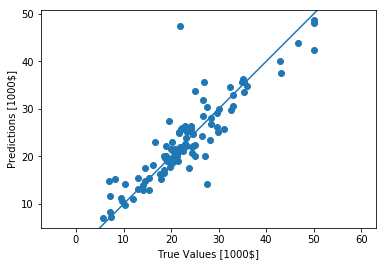

In [14]:
test_predictions = model.predict(test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [1000$]')
plt.ylabel('Predictions [1000$]')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

In [34]:
#print(test_data[0])
print("test_labels[:5]:%r" % (test_labels[:5]))
#print("test_labels[:5]:", (test_data.shape))
test0 = np.reshape(test_data[:5][:], [5, 13])
#print(test0.shape)
test_predict = model.predict(test0)
print("test_predict:%r" % (test_predict))

test_labels[:5]:array([ 7.2, 18.8, 19. , 27. , 22.2])
test_predict:array([[ 9.641433],
       [20.630861],
       [22.587072],
       [32.604004],
       [27.24244 ]], dtype=float32)


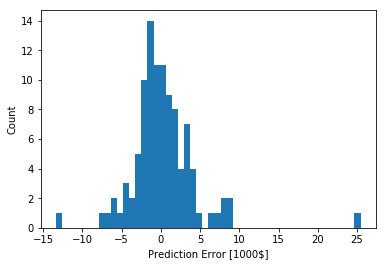

In [15]:
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [1000$]")
_ = plt.ylabel("Count")

## Conclusion

This notebook introduced a few techniques to handle a regression problem.

* Mean Squared Error (MSE) is a common loss function used for regression problems (different than classification problems).
* Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
* When input data features have values with different ranges, each feature should be scaled independently.
* If there is not much training data, prefer a small network with few hidden layers to avoid overfitting.
* Early stopping is a useful technique to prevent overfitting.